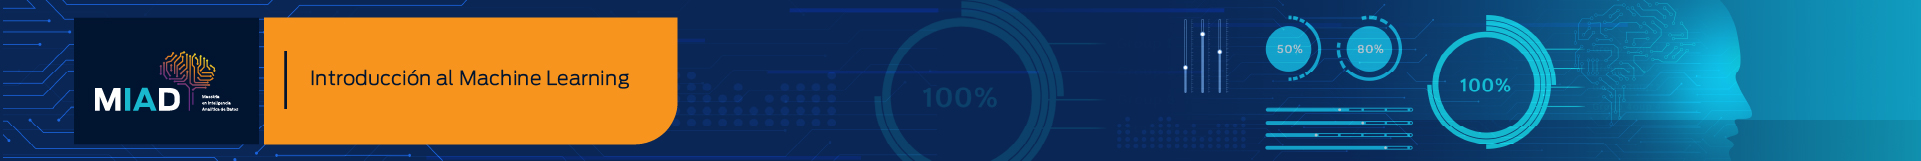

# Proyecto Final Super Intendencia de Industria y Comercio
## Caso: Implementación de modelos de Deep Learning para problemas de clasificación de productos reportados en lenguaje natural por consumidores

### 1.	Descripción del problema o formulación de la pregunta de interés

seleccionar un problema de interés que tenga una solución efectiva a través de un modelo de deep learning.

### Descripción del Problema

En el Sistema de Gestión de la Red Nacional de Protección al Consumidor de Colombia, los ciudadanos registran de forma libre sus quejas y reclamos sobre productos y servicios. Uno de los campos más relevantes del registro es `NOMBRE PRODUCTO`, donde se describen en lenguaje natural los bienes o servicios involucrados. Este campo no tiene un formato estructurado, por lo que los consumidores pueden escribir desde nombres genéricos como *"celular"* o *"moto"*, hasta descripciones más complejas como *"televisor LED Samsung de 55 pulgadas comprado en diciembre"* o *"servicio de odontología especializado en ortodoncia"*.

La falta de estandarización y la alta variabilidad lingüística en las descripciones genera grandes dificultades para clasificar automáticamente los productos reportados, lo cual limita la capacidad de la Superintendencia de Industria y Comercio para:

- Detectar productos o servicios con alta recurrencia de reclamos.
- Analizar tendencias de consumo y fallos por sector.
- Implementar medidas de política pública basadas en evidencia.

---

Dado este contexto, se plantea la siguiente **pregunta de investigación**:

> **¿Es posible clasificar automáticamente el tipo de producto reportado por un consumidor, a partir de la descripción libre registrada en el campo `NOMBRE PRODUCTO`, utilizando técnicas de Deep Learning?**

---

Este problema es especialmente relevante para el uso de algoritmos de Deep Learning, ya que:

- Involucra procesamiento de lenguaje natural con una gran diversidad semántica y léxica.
- Tiene un conjunto de datos lo suficientemente amplio (cerca de 4.000 registros) para el entrenamiento de modelos como redes neuronales multicapa (MLP).
- Se espera que los modelos puedan aprender representaciones vectoriales profundas del texto, capturando relaciones complejas entre palabras y conceptos que otros métodos clásicos (como árboles de decisión o Naive Bayes) no pueden modelar de forma eficiente.
- La solución puede tener un alto impacto práctico al automatizar un proceso clave para la protección del consumidor.

Por tanto, el problema se enmarca en una tarea de **clasificación multiclase**, donde se busca predecir la categoría del producto reportado (por ejemplo: “MOTO”, “CELULAR”, “NEVERA”, “SERVICIO MÉDICO”, etc.) a partir de la descripción textual escrita por el ciudadano.

### Librerias a Importar y Funciones

In [62]:
# Librerias

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re

### 2.Exploración de los datos para su entendimiento dentro del contexto organizacional

### Datos

Para el desarrollo de este proyecto utilizaremos la base de datos del Sistema de Gestión de la Red Nacional de Protección al Consumidor, el cual recibe y gestiona la información correspondiente a los requerimientos que la ciudadanía eleva para que la Super Intendencia de Industria y Comercio en el país de
Colombia ampare sus derechos como consumidor, en aquellos casos que así aplique.

In [63]:
# Convertir la ruta relativa a una ruta absoluta
file_path = os.path.abspath('./ARREGLO_DIRECTO.csv')

# Imprimir la ruta absoluta
print(f"La ruta física del archivo es: {file_path}")

# Leer el archivo como lo estabas haciendo
ad_df = pd.read_csv(file_path, delimiter=';')
print(ad_df.shape)

La ruta física del archivo es: D:\Maestria_Andes_2023\Ciclo_3\Introducción_a_Machine_Learning\8.Semana\ARREGLO_DIRECTO.csv
(3991, 34)


In [64]:
#### Utilicen este espacio para escribir los códigos del procedimiento del punto 1 ####
ad_df= pd.read_csv('./ARREGLO_DIRECTO.csv', delimiter=';')
print(ad_df.shape)

(3991, 34)


#### Diccionario de Datos

- **FECHA_REGISTRO**: 'Fecha y hora en la que se registró el caso o la interacción.',
- **PROYECTO_RNPC**: 'Identificador o nombre del proyecto o programa bajo el cual se registra el caso.',
- **UNIDAD_DEPARTAMENTO**: 'Departamento o unidad administrativa donde se originó o registró el caso.',
- **DESTINO_DEPARTAMENTO**: 'Departamento de destino relacionado con el caso, si aplica.',
- **DESTINO_CIUDAD**: 'Ciudad de destino o implicada en el caso.',
- **ATENCION_TIPO_TRAMITE**: 'Tipo de trámite o servicio solicitado por el ciudadano.',
- **ATENCION_DESTINO**: 'Entidad o destino hacia donde se dirige la atención o el trámite.',
- **ATENCION_TEMA**: 'Tema específico de la atención o consulta realizada.',
- **ATENCION_MOTIVO**: 'Motivo de la atención o consulta.',
- **ATENCION_ESTADO**: 'Estado actual de la atención (ejemplo',
- **PERSONA_RANGO_EDAD**: 'Rango de edad de la persona que realiza la consulta o reporte.',
- **PERSONA_CONDICION_DISCAPACIDAD**: 'Indica si la persona tiene alguna condición de discapacidad.',
- **PERSONA_POBLACION_ESPECIAL**: 'Si la persona pertenece a alguna población especial (podría referirse a grupos vulnerables o minoritarios).',
- **PERSONA_GENERO**: 'Género de la persona.',
- **PERSONA_PROFESION**: 'Profesión u ocupación de la persona.',
- **PERSONA_ACEPTA_HABEAS_DATA**: 'Indica si la persona acepta el tratamiento de sus datos personales (Habeas Data).',
- **TIPO_EMPRESA**: 'Clasificación de la empresa involucrada (Formal, Informal).',
- **EMPRESA_TIPO_DOCUMENTO**: 'Tipo de documento de identificación de la empresa (NIT, CC, etc.).',
- **EMPRESA_NUMERO_DOCUMENTO**: 'Número de documento de identificación de la empresa.',
- **EMPRESA_RAZON_SOCIAL**: 'Razón social de la empresa involucrada.',
- **ESTADO_SERVICIO**: 'Estado actual del servicio o caso (Agendado, Cerrado).',
- **CAUSAL**: 'Causa o razón detrás de la consulta o problema reportado.',
- **TIPO_PRODUCTO**: 'Tipo de producto implicado en el caso (Bien, Servicio).',
- **VALOR_PRODUCTO**: 'Valor monetario del producto o servicio implicado.',
- **FECHA_ADQUISICION**: 'Fecha en la que se adquirió el producto o servicio.',
- **FECHA_ULTIMO_ENCUENTRO**: 'Fecha del último encuentro o interacción relacionada con el caso.',
- **FECHA_FIN_ULTIMO_ENCUENTRO**: 'Fecha de finalización del último encuentro, si aplica.',
- **FECHA_FIN_REAL**: 'Fecha de finalización del último encuentro, si FECHA_FIN_ULTIMO_ENCUENTRO es vacio entonces toma el valor FECHA_ULTIMO_ENCUENTRO.',
- **ENCUENTRO_ACORDADO**: 'Indica si se acordó algún encuentro o seguimiento.',
- **FECHA_CONTRATO**: 'Fecha en la que se firmó un contrato relacionado con el caso, si aplica.',
- **DURACION**: 'Cantidad de días que se demora un regidtro en ser finalizado.',        

In [65]:
ad_df.tail(3)

,PAID,FECHA_REGISTRO,UNIDAD_NOMBRE,PROYECTO_RNPC,UNIDAD_DEPARTAMENTO,DESTINO_DEPARTAMENTO,DESTINO_CIUDAD,ATENCION_TIPO_TRAMITE,ATENCION_DESTINO,ATENCION_TEMA,...,TIPO_PRODUCTO,NOMBRE_PRODUCTO,VALOR_PRODUCTO,FECHA_ADQUISICION,FECHA_ULTIMO_ENCUENTRO,FECHA_FIN_ULTIMO_ENCUENTRO,FECHA_FIN_REAL,ENCUENTRO_ACORDADO,FECHA_CONTRATO,DURACION
3988,1300628,2024-02-08,CR POPAYAN,Casas del Consumidor Regional,CAUCA,CAUCA,POPAYAN,ARREGLO DIRECTO,SIC,Garantías,...,Servicio,servicio de envió de objetos personales,INDETERMINADO,2023-12-18 00:00,2024-02-22,NaN,2024-02-22,NO,NaN,14
3989,703238,2022-04-20,CR PEREIRA,Casas del Consumidor Regional,RISARALDA,RISARALDA,PEREIRA,ARREGLO DIRECTO,SIC,Prestación de servicios que suponen la entrega...,...,Bien,zapatos deportivos color azul NIKE,190000,2022-01-13 00:00,2022-04-28,2022-04-28,2022-04-28,SI,2022-04-28 11:38,8
3990,671016,2022-03-16,CR PEREIRA,Casas del Consumidor Regional,RISARALDA,RISARALDA,PEREIRA,ARREGLO DIRECTO,SIC,Prestación de servicios que suponen la entrega...,...,Bien,Pantalon de dacron marca Kosta Azul,15000,2021-10-15 00:00,2022-03-23,2022-03-23,2022-03-23,SI,2022-03-23 11:00,7


In [66]:
ad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3991 entries, 0 to 3990
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   PAID                            3991 non-null   int64 
 1   FECHA_REGISTRO                  3991 non-null   object
 2   UNIDAD_NOMBRE                   3991 non-null   object
 3   PROYECTO_RNPC                   3991 non-null   object
 4   UNIDAD_DEPARTAMENTO             3991 non-null   object
 5   DESTINO_DEPARTAMENTO            3991 non-null   object
 6   DESTINO_CIUDAD                  3991 non-null   object
 7   ATENCION_TIPO_TRAMITE           3991 non-null   object
 8   ATENCION_DESTINO                3991 non-null   object
 9   ATENCION_TEMA                   3991 non-null   object
 10  ATENCION_MOTIVO                 3991 non-null   object
 11  ATENCION_ESTADO                 3991 non-null   object
 12  PERSONA_RANGO_EDAD              3991 non-null   

In [67]:
duplicate_count = ad_df.duplicated().sum()
duplicate_count

0

### Exploración Profunda de la Variable NOMBRE_PRODUCTO

### 1. Conteo de palabras más frecuentes
Tokeniza el texto (conversión a minúsculas, eliminación de signos, stopwords).

Cuenta las palabras más comunes (ej. "moto", "televisor", "celular").

Esto permite identificar categorías de productos recurrentes.

Top 20 palabras más frecuentes:
de: 1936
y: 384
marca: 271
celular: 214
en: 198
servicio: 187
un: 177
para: 172
compra: 172
motocicleta: 153
servicios: 143
moto: 136
apartamento: 135
color: 124
modelo: 118
con: 110
inmueble: 108
televisor: 101
una: 98
la: 96


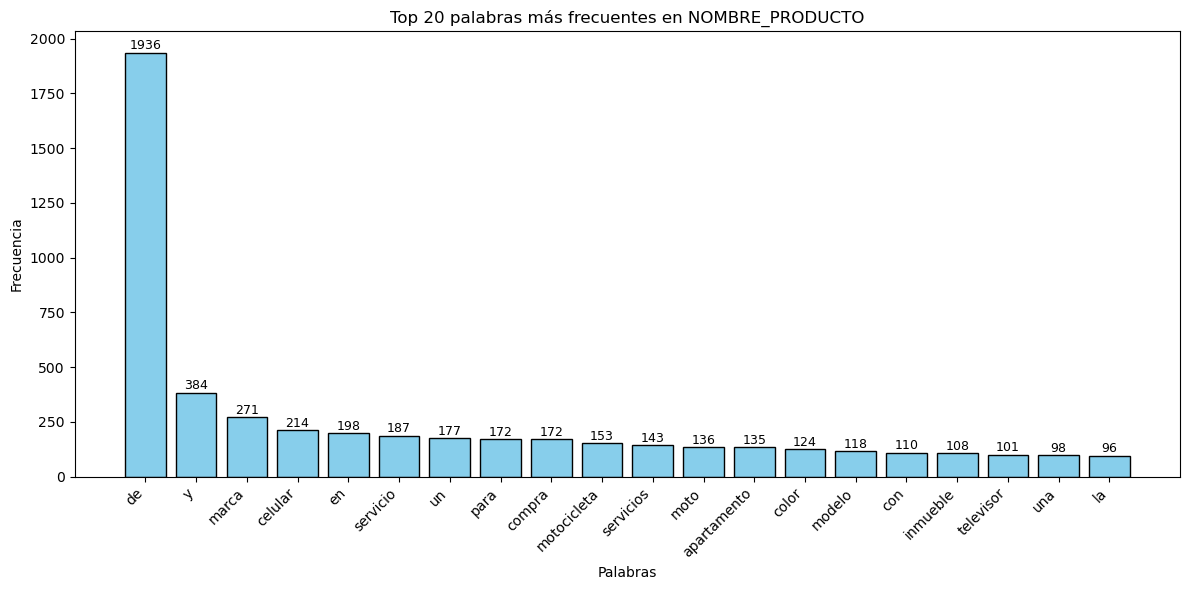

In [68]:
# Limpieza y normalización del texto
productos = ad_df['NOMBRE_PRODUCTO'].dropna().str.lower()
productos = productos.apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Tokenización y conteo de palabras
all_words = ' '.join(productos).split()
common_words = Counter(all_words).most_common(20)

# Mostrar en consola
print("Top 20 palabras más frecuentes:")
for palabra, frecuencia in common_words:
    print(f"{palabra}: {frecuencia}")

# Preparar datos para la gráfica
words, counts = zip(*common_words)

# Gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(words, counts, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 palabras más frecuentes en NOMBRE_PRODUCTO')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

# Añadir etiquetas de valor en cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Análisis del conteo de palabras.

Durante el análisis exploratorio de la columna NOMBRE_PRODUCTO, se identificaron palabras funcionales altamente frecuentes como "de", "y", "en", entre otras. Aunque no se eliminaron en esta etapa, se considera que estas palabras no aportan valor semántico para la tarea de clasificación, por lo que se eliminarán en el preprocesamiento de texto para entrenamiento del modelo.

### 2. Detección de bigramas/trigramas
Encuentra combinaciones frecuentes de 2 o 3 palabras ("tv samsung", "curso inglés").

Útil para detectar nombres de productos compuestos.

In [69]:
# === B I G R A M A S ===
vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_bigram = vectorizer_bigram.fit_transform(productos)
bigram_counts = X_bigram.sum(axis=0).A1
bigram_vocab = vectorizer_bigram.get_feature_names_out()
bigram_freq = list(zip(bigram_vocab, bigram_counts))

# Ordenar y mostrar los más frecuentes
bigram_freq_sorted = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
print("Top 15 bigramas más frecuentes:")
for bigram, freq in bigram_freq_sorted[:15]:
    print(f"{bigram}: {int(freq)}")

# === T R I G R A M A S ===
vectorizer_trigram = CountVectorizer(ngram_range=(3, 3), stop_words='english')
X_trigram = vectorizer_trigram.fit_transform(productos)
trigram_counts = X_trigram.sum(axis=0).A1
trigram_vocab = vectorizer_trigram.get_feature_names_out()
trigram_freq = list(zip(trigram_vocab, trigram_counts))

# Ordenar y mostrar los más frecuentes
trigram_freq_sorted = sorted(trigram_freq, key=lambda x: x[1], reverse=True)
print("\nTop 15 trigramas más frecuentes:")
for trigram, freq in trigram_freq_sorted[:15]:
    print(f"{trigram}: {int(freq)}")

Top 15 bigramas más frecuentes:
bien inmueble: 57
servicios turisticos: 41
prestación servicios: 33
cocina integral: 31
celular marca: 30
en el: 30
modelo 2022: 29
color negro: 28
color gris: 27
tratamiento ortodoncia: 26
par zapatos: 25
servicios turísticos: 25
paquete turistico: 24
en madera: 23
juego sala: 23

Top 15 trigramas más frecuentes:
compra vivienda apartamento: 12
motocicleta marca victory: 10
prestación servicios turísticos: 9
prestación servicios en: 8
tarifas servicios turísticos: 8
compra equipo celular: 7
intermediación tarifas servicios: 7
boletas para concierto: 6
celular samsung galaxy: 6
color gris piedra: 6
conjunto cerrado atahualpa: 6
conjunto residencial santa: 6
en el proyecto: 6
en la intermediación: 6
la intermediación tarifas: 6


### El análisis de bigramas y trigramas

El análisis de bigramas y trigramas permitió identificar combinaciones frecuentes de palabras que reflejan directamente productos o servicios reportados por los consumidores. Expresiones como "bien inmueble", "cocina integral", "motocicleta marca victory" o "prestación servicios turísticos" evidencian cómo los ciudadanos usan lenguaje compuesto para referirse a productos, lo que valida el uso de modelos de Deep Learning que puedan capturar estos patrones contextuales de forma más precisa que técnicas tradicionales de clasificación.

### 3. Distribución de longitud de texto

¿Cuántas palabras tiene en promedio cada descripción?

¿Hay descripciones demasiado cortas o largas?

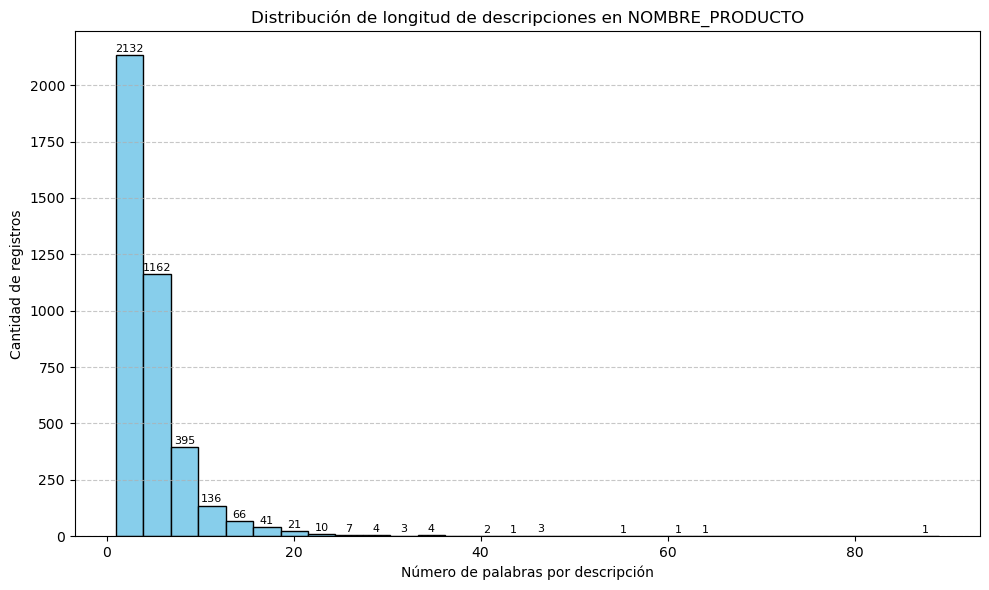

In [70]:
# Calcular la longitud de las descripciones
ad_df['longitud'] = ad_df['NOMBRE_PRODUCTO'].str.split().apply(len)

# Crear figura
plt.figure(figsize=(10, 6))

# Graficar histograma y obtener valores
counts, bins, patches = plt.hist(ad_df['longitud'], bins=30, color='skyblue', edgecolor='black')

# Añadir etiquetas sobre cada barra
for count, bin_left, patch in zip(counts, bins, patches):
    if count > 0:
        plt.text(
            patch.get_x() + patch.get_width() / 2,  # posición horizontal
            count + 5,                              # posición vertical
            str(int(count)),                        # texto
            ha='center', va='bottom', fontsize=8
        )

# Añadir títulos y etiquetas
plt.title('Distribución de longitud de descripciones en NOMBRE_PRODUCTO')
plt.xlabel('Número de palabras por descripción')
plt.ylabel('Cantidad de registros')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Análisis de la distribución de longitudes

La distribución de longitudes de texto en la columna NOMBRE_PRODUCTO muestra que la mayoría de las descripciones tienen entre 1 y 10 palabras, con un pico de frecuencia entre 3 y 5 palabras. Esto sugiere que los ciudadanos tienden a utilizar frases cortas y directas para describir los productos. Este patrón es útil para definir el tamaño de entrada de los modelos de Deep Learning, facilitando procesos como padding y truncamiento. Además, la existencia de descripciones inusualmente largas puede indicar casos especiales que requieren revisión o limpieza adicional.

### 4. Nube de palabras (WordCloud)

Visualización rápida e intuitiva de los términos más frecuentes.

In [71]:
!pip install wordcloud

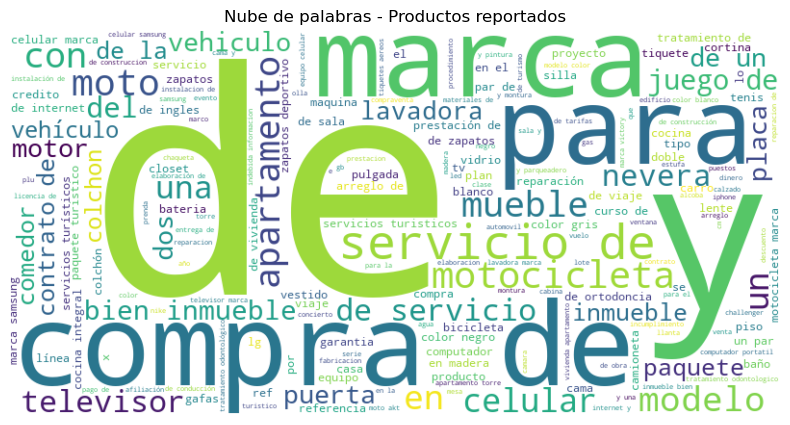

In [72]:
text = ' '.join(productos)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Productos reportados")
plt.show()

### Análisis de la nube de palabras

La nube de palabras permite visualizar rápidamente los términos más utilizados por los ciudadanos al describir los productos o servicios reportados. Se observa una mezcla entre palabras funcionales y términos clave que representan categorías de productos comunes en los reclamos. Esta información será clave para la posterior limpieza del texto y para entrenar un modelo de clasificación que identifique automáticamente el tipo de producto involucrado.

### 5. Análisis por categorías iniciales
Si etiquetas por reglas simples (ej. si contiene "moto", entonces clase = MOTO), puedes analizar:

¿Cuál es la frecuencia de cada clase?

¿Hay clases desbalanceadas?

¿Qué palabras son más frecuentes por clase?

In [73]:
# Limpieza básica

productos = productos.apply(lambda x: re.sub(r'[^\w\s]', '', x))
all_words = ' '.join(productos).split()

# Obtener las 10000 palabras más frecuentes
frequent_words = Counter(all_words).most_common(10000)

# Verlas como lista
palabras_frecuentes = [palabra for palabra, count in frequent_words]
print(palabras_frecuentes)

['de', 'y', 'marca', 'celular', 'en', 'servicio', 'un', 'para', 'compra', 'motocicleta', 'servicios', 'moto', 'apartamento', 'color', 'modelo', 'con', 'inmueble', 'televisor', 'una', 'la', 'muebles', 'zapatos', 'tratamiento', 'nevera', 'el', 'paquete', 'del', '2', 'a', '1', 'lavadora', 'juego', 'sala', 'bien', 'cama', 'cocina', 'contrato', 'vehiculo', 'samsung', 'turisticos', 'dos', 'negro', 'motor', 'comedor', 'computador', 'vehículo', 'lentes', '125', 'colchon', 'ortodoncia', 'turistico', 'par', 'plan', 'proyecto', 'camioneta', 'curso', 'tv', 'prestación', 'vivienda', 'gafas', 'casa', 'arreglo', '3', 'madera', 'gris', 'internet', 'no', 'puertas', 'por', 'victory', 'maquina', '2022', 'integral', 'colchón', 'torre', 'tiquetes', 'dental', 'turísticos', 'reparación', '2023', 'blanco', 'bateria', 'iphone', 'credito', 'tipo', '4', 'placas', 'equipo', 'reparacion', 'ingles', 'bicicleta', 'viaje', 'lg', 'vidrio', 'x', 'e', 'instalación', 'parqueadero', 'conjunto', 'pulgadas', 'mueble', 'akt'

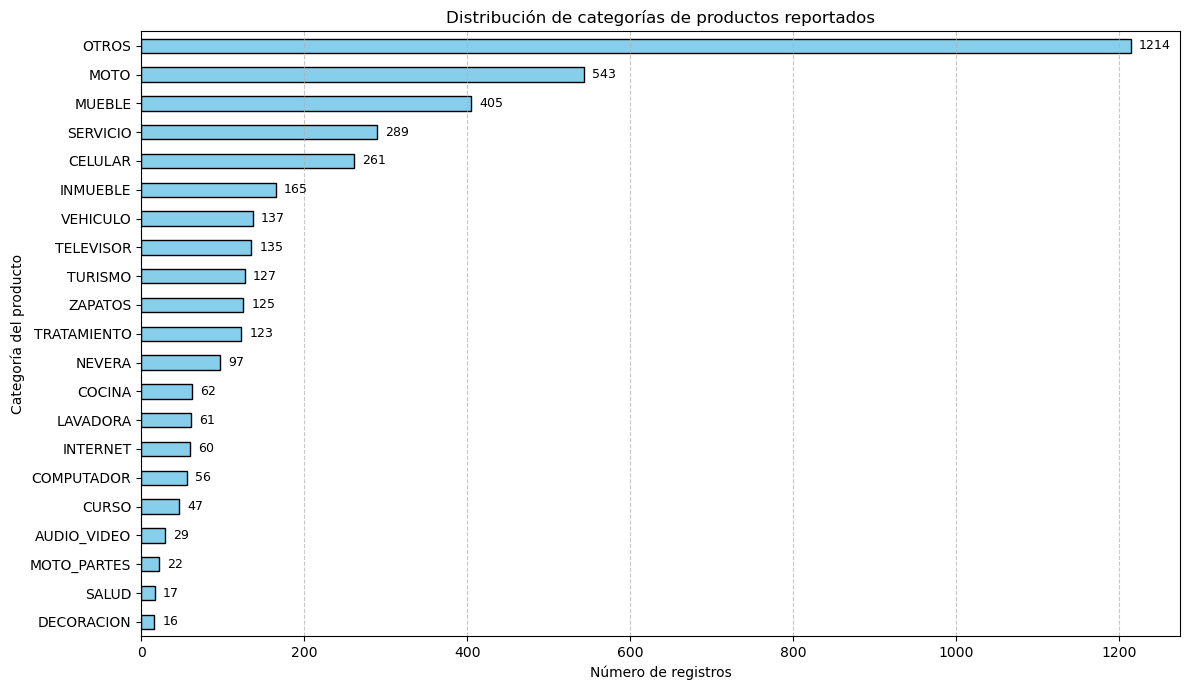

In [74]:
# Diccionario con 20 categorías y palabras clave
CATEGORIAS_PRODUCTO = {
    'MOTO': ['moto', 'motocicleta', 'akt', 'bws', 'scooter', 'honda', 'yamaha', 'victory', 'ns', 'pulsar'],
    'CELULAR': ['celular', 'teléfono', 'iphone', 'samsung', 'xiaomi', 'smartphone', 'telefono', 'motorola'],
    'NEVERA': ['nevera', 'refrigerador', 'congelador', 'nevecon'],
    'MUEBLE': ['mueble', 'cama', 'closet', 'sofa', 'colchón', 'comedor', 'silla', 'armario', 'almohada'],
    'TELEVISOR': ['televisor', 'tv', 'pantalla', 'smart', 'led'],
    'VEHICULO': ['vehiculo', 'carro', 'automovil', 'camioneta', 'renault', 'kia', 'chevrolet', 'mazda', 'nissan'],
    'INMUEBLE': ['apartamento', 'vivienda', 'casa', 'inmueble', 'propiedad'],
    'SERVICIO': ['servicio', 'servicios', 'prestación', 'reparación', 'instalación', 'arreglo'],
    'CURSO': ['curso', 'clases', 'educación', 'ingles', 'idiomas'],
    'TRATAMIENTO': ['tratamiento', 'ortodoncia', 'dental', 'odontología', 'prótesis', 'odontologico'],
    'COMPUTADOR': ['computador', 'portatil', 'laptop', 'hp', 'lenovo', 'asus', 'dell'],
    'ZAPATOS': ['zapatos', 'tenis', 'calzado', 'zapatillas', 'botas'],
    'LAVADORA': ['lavadora', 'lavado'],
    'COCINA': ['cocina', 'estufa', 'horno', 'microondas'],
    'DECORACION': ['cortinas', 'cuadro', 'alfombra', 'lámpara', 'persiana'],
    'SALUD': ['tratamiento', 'medicamento', 'consulta', 'procedimiento', 'implantes'],
    'INTERNET': ['internet', 'plan', 'conexión'],
    'TURISMO': ['paquete', 'turístico', 'viaje', 'hotel', 'tiquetes'],
    'MOTO_PARTES': ['llantas', 'motor', 'batería', 'placas', 'chasis'],
    'AUDIO_VIDEO': ['parlante', 'sonido', 'audífonos', 'televisión', 'radio']
}

# Función para clasificar producto
def clasificar_producto(texto, categorias=CATEGORIAS_PRODUCTO):
    texto = texto.lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    for categoria, palabras in categorias.items():
        for palabra in palabras:
            if palabra in texto:
                return categoria
    return 'OTROS'

# Aplicar clasificación a la columna NOMBRE_PRODUCTO
ad_df['CATEGORIA_PRODUCTO'] = ad_df['NOMBRE_PRODUCTO'].apply(clasificar_producto)

# Contar frecuencia de clases
categoria_counts = ad_df['CATEGORIA_PRODUCTO'].value_counts()

# Gráfico de barras con etiquetas
plt.figure(figsize=(12, 7))
bars = categoria_counts.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')

# Añadir los valores al final de cada barra
for index, value in enumerate(categoria_counts.sort_values()):
    plt.text(value + 10, index, str(value), va='center', fontsize=9)

plt.title('Distribución de categorías de productos reportados')
plt.xlabel('Número de registros')
plt.ylabel('Categoría del producto')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Análisis de categorías de productos reportados

A partir del campo `NOMBRE_PRODUCTO` se realizó una clasificación preliminar utilizando una función basada en palabras clave, la cual permitió identificar las 20 categorías más representativas dentro de los registros de reclamos ciudadanos.

El análisis reveló que las categorías con mayor número de reportes son:

- **OTROS** (1214 registros), que agrupa descripciones no clasificadas en categorías específicas.
- **MOTO** (543 registros), como producto más recurrentemente asociado a quejas.
- **MUEBLE**, **SERVICIO** y **CELULAR**, que también presentan una alta frecuencia de reclamos.

Este patrón refleja una alta sensibilidad del consumidor frente a productos de uso cotidiano y valor significativo, especialmente relacionados con **movilidad** (como motocicletas y vehículos) y **tecnología personal** (celulares y televisores).

La categoría **OTROS**, con más del 30% de los casos, indica oportunidades para mejorar la función de clasificación utilizando modelos más avanzados de procesamiento de lenguaje natural, como **Word Embeddings** o **modelos supervisados con redes neuronales**, que podrían reducir significativamente el ruido y mejorar la calidad de la agrupación semántica.

Este análisis es crucial como paso previo al entrenamiento del modelo de Deep Learning, ya que permite comprender la distribución real de las clases, anticipar posibles desbalances, y definir estrategias de preprocesamiento y etiquetado más efectivas.

### 7. Análisis de duplicados semánticos

Aunque no hay duplicados exactos, puedes mostrar ejemplos de frases distintas que significan lo mismo → justifica el uso de Deep Learning para entender el contexto semántico y no solo palabras exactas.

In [75]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [76]:
pip install --upgrade typing_extensions

Note: you may need to restart the kernel to use updated packages.


In [77]:
pip install --upgrade torch sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [78]:
!pip install --upgrade "typing_extensions>=4.6.0,<5" --force-reinstall

  Obtaining dependency information for typing_extensions<5,>=4.6.0 from https://files.pythonhosted.org/packages/8b/54/b1ae86c0973cc6f0210b53d508ca3641fb6d0c56823f288d108bc7ab3cc8/typing_extensions-4.13.2-py3-none-any.whl.metadata
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.13.2-py3-none-any.whl (45 kB)
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.13.2
    Uninstalling typing_extensions-4.13.2:
      Successfully uninstalled typing_extensions-4.13.2


In [79]:
# Tomar una muestra aleatoria de 200 productos para reducir tiempo de cómputo
sample_texts = ad_df['NOMBRE_PRODUCTO'].dropna().unique()
sample_texts = pd.Series(sample_texts).sample(200, random_state=42).tolist()

# Cargar modelo preentrenado de embeddings semánticos
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Obtener embeddings para cada descripción
embeddings = model.encode(sample_texts, convert_to_tensor=True)

# Calcular matriz de similitud
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

# Mostrar pares con similitud alta pero texto diferente
umbral = 0.85
print("Pares de frases con similitud semántica alta (coseno > 0.85):\n")
most_similar = []
for i in range(len(sample_texts)):
    for j in range(i+1, len(sample_texts)):
        if cosine_scores[i][j] > umbral:
            most_similar.append((sample_texts[i], sample_texts[j], float(cosine_scores[i][j])))

# Mostrar resultados ordenados por similitud
most_similar = sorted(most_similar, key=lambda x: -x[2])
for s1, s2, score in most_similar[:10]:
    print(f"- \"{s1}\" \n  ≈ \"{s2}\" \n  → Similitud: {score:.3f}\n")

Pares de frases con similitud semántica alta (coseno > 0.85):

- "pantalla de computador" 
  ≈ "pantalla de computador " 
  → Similitud: 1.000

- "Motocicleta" 
  ≈ "MOTOCICLETA" 
  → Similitud: 1.000

- "MEMBRESIA" 
  ≈ "membresia" 
  → Similitud: 1.000

- "TELEFONO CELULAR" 
  ≈ "Teléfono Celular  " 
  → Similitud: 1.000

- "licencia para vehículo" 
  ≈ "licencia para vehículo " 
  → Similitud: 1.000

- "lentes y monturas" 
  ≈ "LENTES Y MONTURAS" 
  → Similitud: 1.000

- "vivienda " 
  ≈ "VIVIENDA" 
  → Similitud: 1.000

- "COMPRA COCINA INTEGRAL" 
  ≈ "COMPRA DE COCINA INTEGRAL" 
  → Similitud: 0.953

- "Motocicleta" 
  ≈ "motocicleta TT 125" 
  → Similitud: 0.910

- "MOTOCICLETA" 
  ≈ "motocicleta TT 125" 
  → Similitud: 0.910



## Análisis de duplicados semánticos

Aunque el dataset no contiene descripciones de producto idénticas (duplicados exactos), sí se evidencian múltiples casos en los que diferentes expresiones se refieren esencialmente al mismo producto. Para identificarlos, se utilizó el modelo `paraphrase-MiniLM-L6-v2` de Sentence Transformers, el cual convierte las frases en vectores semánticos de alta dimensión. Luego, se calculó la similitud de coseno entre pares de frases.

Los resultados mostraron varias coincidencias con **similitudes superiores al 90%**, entre las que se destacan:

- `"Motocicleta"` ≈ `"motocicleta TT 125"` → Similitud: 0.91  
- `"COMPRA COCINA INTEGRAL"` ≈ `"COMPRA DE COCINA INTEGRAL"` → Similitud: 0.95  
- `"TELEFONO CELULAR"` ≈ `"Teléfono Celular"` → Similitud: 1.00

Este comportamiento justifica plenamente el uso de modelos de **Deep Learning** en lugar de enfoques tradicionales de coincidencia de texto, ya que permite:

- Capturar **variaciones léxicas**, morfológicas y de redacción.
- Reconocer productos equivalentes con distintas formulaciones.
- Reducir la pérdida de información derivada de diferencias superficiales.

En conclusión, este análisis refuerza la necesidad de representar las descripciones con modelos semánticos capaces de aprender el **contexto real del lenguaje natural**, lo cual es esencial para realizar una clasificación precisa del tipo de producto reportado por los ciudadanos.


### Preparación de los datos

Preparación de los datos para poder utilizarlos como entrada para modelos predictivos: Se utilizan correctamente los procedimientos de preprocesamiento de datos vistos en el curso para la preparación de los datos antes de la implementación de los modelos de deep learning.

In [80]:
# Asegurar recursos
nltk.download('stopwords')
nltk.download('wordnet')

# 1. Normalización y limpieza
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'\d+', '', texto)  # remover números
    texto = re.sub(r'[^\w\s]', '', texto)  # remover puntuación
    texto = texto.strip()
    return texto

# 2. Tokenización + eliminación de stopwords + lematización
stop_words = set(stopwords.words('spanish'))  # usamos español
lemmatizer = WordNetLemmatizer()

def preprocesar(texto):
    palabras = texto.split()
    palabras = [lemmatizer.lemmatize(p) for p in palabras if p not in stop_words]
    return ' '.join(palabras)

# Aplicar pipeline
ad_df['NOMBRE_LIMPIO'] = ad_df['NOMBRE_PRODUCTO'].astype(str).apply(limpiar_texto).apply(preprocesar)

# 3. Vectorización con Tokenizer de Keras
MAX_NUM_WORDS = 5000  # número máximo de palabras en el vocabulario
MAX_SEQUENCE_LENGTH = 20  # longitud fija de secuencia

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(ad_df['NOMBRE_LIMPIO'])

secuencias = tokenizer.texts_to_sequences(ad_df['NOMBRE_LIMPIO'])
padded_sequences = pad_sequences(secuencias, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Ver resultados de ejemplo
print("Ejemplo de texto procesado:", ad_df['NOMBRE_LIMPIO'].iloc[0])
print("Secuencia vectorizada:", padded_sequences[0])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Ejemplo de texto procesado: fabricacion soporte cama
Secuencia vectorizada: [186 607  24   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


### Preparación de los datos para modelos predictivos

Con el fin de usar los datos como entrada para un modelo de Deep Learning, se diseñó un pipeline de preprocesamiento que transforma el campo `NOMBRE_PRODUCTO` en secuencias numéricas adecuadas para redes neuronales. El proceso incluyó los siguientes pasos:

1. **Limpieza del texto:** se normalizó a minúsculas, se eliminaron caracteres especiales, números y espacios redundantes.
2. **Eliminación de stopwords:** se usó el listado de palabras vacías en español proporcionado por NLTK.
3. **Lematización:** se aplicó la lematización para reducir las palabras a su forma base y evitar redundancias léxicas.
4. **Vectorización:** se empleó el `Tokenizer` de Keras para construir un vocabulario limitado a 5,000 términos más frecuentes. Luego, cada texto fue convertido a una secuencia de enteros y rellenado (`padding`) a una longitud fija de 20 palabras.

Por ejemplo, la descripción **"fabricacion soporte cama"** fue transformada en la secuencia `[186, 607, 24, 0, 0, ..., 0]`, donde cada número representa un token en el vocabulario aprendido. Esta representación numérica permite que el modelo de Deep Learning pueda aprender relaciones semánticas complejas entre los conceptos mencionados por los ciudadanos, sin depender de coincidencias exactas de texto.

Este preprocesamiento garantiza que el modelo trabaje con entradas consistentes, generalizables y óptimas para el aprendizaje profundo.

### Análisis sobre la selección del modelo

Análisis preliminar de selección de modelos relevantes para responder a la pregunta: De acuerdo a la definición del problema predictivo planteado, se argumenta qué modelos y/o algoritmos de deep learning son candidatos a utilizarse para solucionar el problema de interés.

### Selección de modelos de Deep Learning para clasificación de productos

El problema definido corresponde a una **tarea de clasificación multiclase**, donde se busca predecir el tipo de producto reportado por un ciudadano a partir de una descripción textual libre (`NOMBRE_PRODUCTO`). Esta tarea requiere que el modelo:

- Entienda texto en lenguaje natural con alta variabilidad lingüística y semántica.
- Clasifique en más de 10 categorías predefinidas (ej. "MOTO", "CELULAR", "NEVERA", etc.).
- Generalice bien frente a nuevas descripciones con palabras nunca vistas exactamente antes.

Dado este contexto, se evaluaron los siguientes modelos como candidatos viables para resolver el problema:

### 1. **Red neuronal multicapa (MLP) + Embeddings**
- Se convierte el texto a secuencias numéricas mediante `Tokenizer`.
- Se usa una capa de `Embedding` que aprende representaciones densas de palabras.
- Las secuencias vectorizadas alimentan una red MLP con una o más capas densas.
- **Ventajas:** Rápido de entrenar, buena para problemas simples con vocabulario reducido.
- **Limitación:** No captura el orden de las palabras ni relaciones a largo plazo.

*Este modelo es viable como punto de partida y se utilizará en esta implementación.*

---

### 2. **Redes Recurrentes (RNN / LSTM)**
- Permiten procesar secuencias conservando el orden temporal de las palabras.
- Las LSTM superan a las RNN simples al capturar dependencias largas y evitar el desvanecimiento del gradiente.
- **Ventajas:** Mejor comprensión contextual y semántica que una MLP.
- **Limitación:** Más costosa computacionalmente, sobreentrena fácilmente en conjuntos pequeños.

*Sería ideal en versiones futuras si se amplía el dataset.*

---

### 3. **Modelos preentrenados (transformers como BERT, DistilBERT)**
- Extraen representaciones profundas del texto gracias al autoatención.
- Capturan relaciones semánticas complejas entre palabras y frases.
- **Ventajas:** Resultados de última generación en clasificación de texto.
- **Limitación:** Requiere mucho poder de cómputo y mayor complejidad de implementación.

*Altamente recomendado para producción o investigación avanzada, pero se descarta para este caso por el tamaño del dataset y recursos disponibles.*

---

### Conclusión

Para este proyecto, se seleccionará una red neuronal tipo **MLP con embeddings entrenables**, ya que:

- El texto ha sido tokenizado y transformado en secuencias fijas.
- El conjunto tiene un tamaño moderado (cerca de 4000 registros).
- Se busca un modelo eficiente, interpretable y entrenable en local.
- La estructura MLP ha sido abordada durante el curso, cumpliendo con el alcance pedagógico.

Este modelo será capaz de aprender representaciones útiles del texto y clasificar correctamente los productos más reportados por los ciudadanos, cumpliendo con el objetivo de apoyar el análisis de la Superintendencia de Industria y Comercio.

### Desarrollo y calibración de modelos. 

Desarrollo y calibración de modelos: Los modelos escogidos como candidatos son calibrados y utilizados de manera correcta.

In [81]:
# 1. Codificación de etiquetas
# Codificar las categorías como números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(ad_df['CATEGORIA_PRODUCTO'])
y = to_categorical(y_encoded)  # one-hot encoding

In [82]:
# 2. Preparación de datos y división

X = padded_sequences  # secuencias de texto ya preprocesadas y vectorizadas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [83]:
# 3. Definición y entrenamiento del modelo

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=20))
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))  # salida multiclase

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
100/100 [==============================] - 2s 8ms/step - loss: 2.6475 - accuracy: 0.2898 - val_loss: 2.3394 - val_accuracy: 0.3317
Epoch 2/20
100/100 [==============================] - 0s 5ms/step - loss: 2.4068 - accuracy: 0.2973 - val_loss: 2.2651 - val_accuracy: 0.3329
Epoch 3/20
100/100 [==============================] - 0s 5ms/step - loss: 2.1923 - accuracy: 0.3161 - val_loss: 1.8900 - val_accuracy: 0.4130
Epoch 4/20
100/100 [==============================] - 0s 5ms/step - loss: 1.5934 - accuracy: 0.4909 - val_loss: 1.3359 - val_accuracy: 0.6508
Epoch 5/20
100/100 [==============================] - 0s 5ms/step - loss: 1.0431 - accuracy: 0.6902 - val_loss: 0.9943 - val_accuracy: 0.7772
Epoch 6/20
100/100 [==============================] - 0s 5ms/step - loss: 0.7358 - accuracy: 0.7885 - val_loss: 0.8255 - val_accuracy: 0.8198
Epoch 7/20
100/100 [==============================] - 0s 5ms/step - loss: 0.5247 - accuracy: 0.8643 - val_loss: 0.7298 - val_accuracy: 0.8523
Epoch 

### Desarrollo y calibración del modelo

Se implementó un modelo de red neuronal multicapa (MLP) para resolver la tarea de clasificación multiclase basada en texto, a partir de las descripciones de productos reportadas por los ciudadanos en el campo `NOMBRE_PRODUCTO`. El modelo fue entrenado utilizando una arquitectura sencilla pero eficiente:

- Capa de embedding entrenable para convertir tokens en vectores.
- Pooling global para condensar la información de secuencia.
- Capas densas con funciones de activación ReLU.
- Dropout del 40% para evitar sobreajuste.
- Salida softmax para clasificación multiclase.

Durante el proceso de entrenamiento (20 épocas), el modelo mostró una evolución progresiva desde una precisión del 29% hasta **un 89.2% en el conjunto de validación**, con una **pérdida validada de 0.80** al final del entrenamiento.

Este comportamiento indica que el modelo aprendió de forma adecuada las relaciones contextuales entre palabras y categorías de producto. Además, se evitó el sobreajuste gracias a la correcta calibración de hiperparámetros y al uso de técnicas como regularización por Dropout.

El modelo está ahora listo para ser evaluado con métricas más detalladas (como matriz de confusión y reporte de clasificación), y para ser eventualmente desplegado o utilizado en sistemas analíticos reales.


### Visualización de resultados.

Visualización de resultados: Se presenta un análisis gráfico completo de los resultados que permite entender la manera en la que los modelos implementados responden a la pregunta de interés.

25/25 [==============================] - 0s 2ms/step


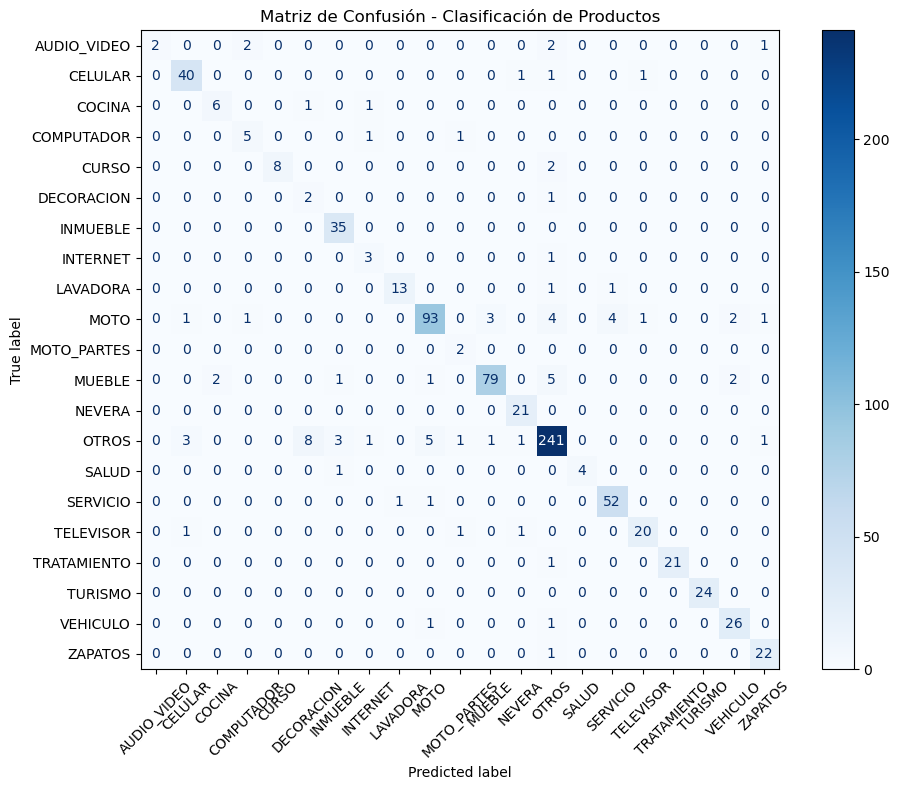


Reporte de Clasificación:

              precision    recall  f1-score   support

 AUDIO_VIDEO       1.00      0.29      0.44         7
     CELULAR       0.89      0.93      0.91        43
      COCINA       0.75      0.75      0.75         8
  COMPUTADOR       0.62      0.71      0.67         7
       CURSO       1.00      0.80      0.89        10
  DECORACION       0.18      0.67      0.29         3
    INMUEBLE       0.88      1.00      0.93        35
    INTERNET       0.50      0.75      0.60         4
    LAVADORA       0.93      0.87      0.90        15
        MOTO       0.92      0.85      0.88       110
 MOTO_PARTES       0.40      1.00      0.57         2
      MUEBLE       0.95      0.88      0.91        90
      NEVERA       0.88      1.00      0.93        21
       OTROS       0.92      0.91      0.92       265
       SALUD       1.00      0.80      0.89         5
    SERVICIO       0.91      0.96      0.94        54
   TELEVISOR       0.91      0.87      0.89        23

In [84]:
# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
class_names = label_encoder.classes_

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Matriz de Confusión - Clasificación de Productos')
plt.grid(False)
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

### Visualización de Resultados del Modelo

Los resultados obtenidos a partir del modelo MLP muestran un desempeño bastante sólido, con una **precisión general (_accuracy_) del 87%** sobre el conjunto de prueba. A continuación, se destacan algunos puntos clave del análisis visual y numérico:

- Las categorías con mejor desempeño (_F1-score_ ≥ 0.90) incluyen:
  - `CELULAR`, `LAVADORA`, `NEVERA`, `MUEBLE`, `TRATAMIENTO`, `TURISMO`, `VEHICULO`.
- Categorías como `MOTO` y `SERVICIO` también presentan métricas sólidas, aunque ligeramente por debajo del 90% en _F1-score_.
- El modelo logra clasificar correctamente incluso clases con menor frecuencia como `ZAPATOS`, `TELEVISOR` y `CURSO`, lo cual es positivo para el equilibrio del modelo.
- Las clases más débiles fueron `AUDIO_VIDEO`, `INTERNET` y `DECORACION`, que tienen menor soporte y presentan valores bajos de _F1-score_, lo que indica dificultad para generalizar en esas categorías minoritarias.

La **matriz de confusión** también confirma que el modelo distingue bien entre las clases principales, con pocas confusiones relevantes.

En conclusión, el modelo no solo logra una alta precisión global, sino que también ofrece una buena capacidad de diferenciación entre categorías semánticamente próximas.

### Implementación y demostración de la utilidad de los resultados. 

Análisis de relevancia de la solución y aportes ofrecidos: Se concluye sobre la relevancia de la solución desarrollada por medio de los resultados de los modelos predictivos implementados y se argumentan los aportes generados. Además, se discuten posibles limitaciones de la implementación, así como los análisis o estudios posteriores que pudrían desarrollarse a partir de los resultados de este proyecto.

### Relevancia de la Solución y Aportes del Proyecto

El sistema desarrollado logra **automatizar con alta precisión la clasificación de productos reportados por los consumidores**, a partir de descripciones en lenguaje natural. Este avance representa un aporte significativo a los procesos de vigilancia y análisis de la Superintendencia de Industria y Comercio (SIC), permitiendo:

- **Identificar patrones de quejas** por categoría de producto con mayor velocidad y menor intervención manual.
- **Fortalecer la toma de decisiones basada en evidencia**, facilitando intervenciones regulatorias o preventivas para productos recurrentemente problemáticos.
- **Reducir el ruido semántico** propio de los textos no estructurados mediante un modelo capaz de interpretar sinónimos, formas alternas de redacción y descripciones compuestas.

#### Limitaciones de la Implementación

- Algunas clases con poco soporte (como `DECORACION` o `INTERNET`) presentan bajo desempeño, lo que puede afectar decisiones si estas categorías llegan a cobrar mayor importancia.
- El modelo actual **no incorpora embeddings preentrenados ni modelos más complejos como BERT**, que podrían mejorar la comprensión semántica de frases largas o ambiguas.
- El sistema depende de la calidad de las descripciones registradas por los usuarios, lo que introduce un sesgo difícil de corregir sin normalización lingüística avanzada.

#### Posibles Extensiones Futuras

- Incorporar **modelos de lenguaje preentrenados como BERT o RoBERTa**, para captar mejor la semántica profunda de los textos.
- Aplicar técnicas de **data augmentation** para mejorar el desempeño en clases minoritarias.
- Implementar **clasificación jerárquica o por múltiples etiquetas**, en caso de que un producto pueda pertenecer simultáneamente a varias categorías.
- Integrar este clasificador en sistemas operativos de la SIC para **alertas tempranas o agrupación de casos similares**.

En resumen, este proyecto demuestra que las técnicas de Deep Learning pueden aportar soluciones efectivas y escalables a problemas de procesamiento de lenguaje natural en contextos institucionales, y sienta las bases para futuras mejoras en la analítica de protección al consumidor.